In [1]:
# Copyright 2020 NVIDIA Corporation. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#|
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# Criteo Example 
Here we'll show how to use NVTabular first as a preprocessing library to prepare the [Criteo Display Advertising Challenge](https://www.kaggle.com/c/criteo-display-ad-challenge) dataset, and then as a dataloader to train a FastAI model on the prepared data. The large memory footprint of the Criteo dataset presents a great opportunity to highlight the advantages of the online fashion in which NVTabular loads and transforms data.

### Data Prep
Before we get started, make sure you've run the [optimize_criteo](https://github.com/NVIDIA/NVTabular/blob/main/examples/optimize_criteo.ipynb) notebook, which will convert the tsv data published by Criteo into the parquet format that our accelerated readers prefer. It's fair to mention at this point that that notebook will take around 30 minutes to run. While we're hoping to release accelerated csv readers in the near future, we also believe that inefficiencies in existing data representations like csv are in no small part a consequence of inefficiencies in the existing hardware/software stack. Accelerating these pipelines on new hardware like GPUs may require us to make new choices about the representations we use to store that data, and parquet represents a strong alternative.

In [2]:
import os
from time import time
import re
import glob
import warnings

# tools for data preproc/loading
import torch
import rmm
import nvtabular as nvt
from nvtabular.ops import Normalize,  Categorify,  LogOp, FillMissing, Clip, get_embedding_sizes
from nvtabular.loader.torch import TorchAsyncItr, DLDataLoader
from nvtabular.utils import device_mem_size, get_rmm_size

# tools for training
from fastai.basics import Learner
from fastai.tabular.model import TabularModel
from fastai.tabular.data import TabularDataLoaders
from fastai.metrics import RocAucBinary, APScoreBinary
from fastai.callback.progress import ProgressCallback

### Initializing the Memory Pool
For applications like the one that follows where RAPIDS will be the only workhorse user of GPU memory and resource, a best practice is to use the RAPIDS Memory Manager library `rmm` to allocate a dedicated pool of GPU memory that allows for fast, asynchronous memory management. Here, we'll dedicate 80% of free GPU memory to this pool to make sure we get the most utilization possible.

In [3]:
rmm.reinitialize(pool_allocator=True, initial_pool_size=get_rmm_size(0.8 * device_mem_size(kind='free')))

/nvtabular/nvtabular/utils.py:47: UserWarning: get_memory_info is not supported. Using total device memory from NVML.
  warnings.warn("get_memory_info is not supported. Using total device memory from NVML.")


### Dataset and Dataset Schema
Once our data is ready, we'll define some high level parameters to describe where our data is and what it "looks like" at a high level.

In [4]:
# define some information about where to get our data
INPUT_DATA_DIR = os.environ.get('INPUT_DATA_DIR', '/raid/criteo/tests/crit_int_pq')
OUTPUT_DATA_DIR = os.environ.get('OUTPUT_DATA_DIR', '/raid/criteo/tests/test_dask') # where we'll save our procesed data to
BATCH_SIZE = int(os.environ.get('BATCH_SIZE', 800000))
PARTS_PER_CHUNK = int(os.environ.get('PARTS_PER_CHUNK', 2))
NUM_TRAIN_DAYS = 23 # number of days worth of data to use for training, the rest will be used for validation

output_train_dir = os.path.join(OUTPUT_DATA_DIR, 'train/')
output_valid_dir = os.path.join(OUTPUT_DATA_DIR, 'valid/')
! mkdir -p $output_train_dir
! mkdir -p $output_valid_dir

In [5]:
! ls $INPUT_DATA_DIR

day_0.parquet	day_14.parquet	day_19.parquet	day_23.parquet	day_6.parquet
day_10.parquet	day_15.parquet	day_1.parquet	day_2.parquet	day_7.parquet
day_11.parquet	day_16.parquet	day_20.parquet	day_3.parquet	day_8.parquet
day_12.parquet	day_17.parquet	day_21.parquet	day_4.parquet	day_9.parquet
day_13.parquet	day_18.parquet	day_22.parquet	day_5.parquet	_metadata


In [6]:
fname = 'day_{}.parquet'
num_days = len([i for i in os.listdir(INPUT_DATA_DIR) if re.match(fname.format('[0-9]{1,2}'), i) is not None])
train_paths = [os.path.join(INPUT_DATA_DIR, fname.format(day)) for day in range(NUM_TRAIN_DAYS)]
valid_paths = [os.path.join(INPUT_DATA_DIR, fname.format(day)) for day in range(NUM_TRAIN_DAYS, num_days)]

### Preprocessing
At this point, our data still isn't in a form that's ideal for consumption by neural networks. The most pressing issues are missing values and the fact that our categorical variables are still represented by random, discrete identifiers, and need to be transformed into contiguous indices that can be leveraged by a learned embedding. Less pressing, but still important for learning dynamics, are the distributions of our continuous variables, which are distributed across multiple orders of magnitude and are uncentered (i.e. E[x] != 0).

We can fix these issues in a conscise and GPU-accelerated manner with an NVTabular `Workflow`. We define our operation pipelines on `ColumnGroups` (list of column names). Then, we initialize the NVTabular `Workflow` and collect train dataset statistics with `.fit()` and apply the transformation to the train and valid dataset with `.transform()`. NVTabular `ops` can be chained with the overloaded `>>` operator.

#### Frequency Thresholding
One interesting thing worth pointing out is that we're using _frequency thresholding_ in our `Categorify` op. This handy functionality will map all categories which occur in the dataset with some threshold level of infrequency (which we've set here to be 15 occurrences throughout the dataset) to the _same_ index, keeping the model from overfitting to sparse signals.

#### Defining the operation pipelines
1. Categorical input features (`CATEGORICAL_COLUMNS`) are `Categorify` with frequency treshold of 15
2. Continuous input features (`CONTINUOUS_COLUMNS`) filled in missing values, clipped, applied logarithmn and normalized

In [7]:
# define our dataset schema
CONTINUOUS_COLUMNS = ['I' + str(x) for x in range(1,14)]
CATEGORICAL_COLUMNS = ['C' + str(x) for x in range(1,27)]
LABEL_COLUMNS = ["label"]

cat_features = CATEGORICAL_COLUMNS >> Categorify(freq_threshold=15, out_path=OUTPUT_DATA_DIR)
cont_features = CONTINUOUS_COLUMNS >> FillMissing() >> Clip(min_value=0) >> LogOp() >> Normalize()
features = cat_features + cont_features + LABEL_COLUMNS

We can visualize the pipeline with `graphviz`.

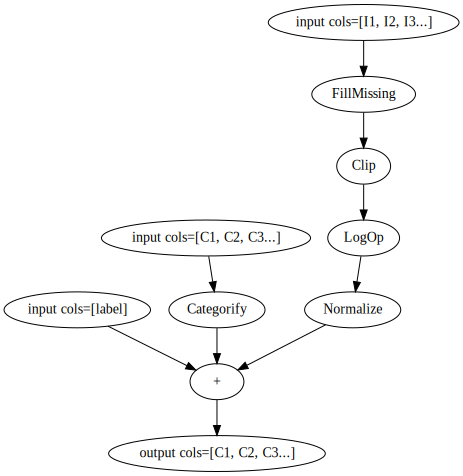

In [8]:
features.graph

We initialize a NVTabular `Workflow` with our pipelines.

In [9]:
workflow = nvt.Workflow(features)

Now instantiate dataset's to partition our dataset (which we couldn't fit into GPU memory)

In [10]:
train_dataset = nvt.Dataset(train_paths, part_mem_fraction=0.2)
valid_dataset = nvt.Dataset(valid_paths, part_mem_fraction=0.2)

Now run them through our workflows to collect statistics on the train set, then transform and save to parquet files.

In [11]:
%%time
workflow.fit(train_dataset)

CPU times: user 4min 1s, sys: 1min 1s, total: 5min 2s
Wall time: 5min 1s


Next, we apply the transformation to the train and valid dataset and persist it to disk.

In [12]:
%%time
workflow.transform(train_dataset).to_parquet(output_path=output_train_dir,
                                         shuffle=nvt.io.Shuffle.PER_PARTITION, 
                                         out_files_per_proc=5)

CPU times: user 7min 18s, sys: 5min 5s, total: 12min 24s
Wall time: 12min 25s


In [13]:
%%time
workflow.transform(valid_dataset).to_parquet(output_path=output_valid_dir)

CPU times: user 17.9 s, sys: 14.9 s, total: 32.9 s
Wall time: 38.6 s


And just like that, we have training and validation sets ready to feed to a model!

## Deep Learning
### Data Loading
We'll start by using the parquet files we just created to feed an NVTabular `TorchAsyncItr`, which will loop through the files in chunks. First, we'll reinitialize our memory pool from earlier to free up some memory so that we can share it with PyTorch.

In [14]:
rmm.reinitialize(pool_allocator=True, initial_pool_size=get_rmm_size(0.3 * device_mem_size(kind='free')))

/nvtabular/nvtabular/utils.py:47: UserWarning: get_memory_info is not supported. Using total device memory from NVML.
  warnings.warn("get_memory_info is not supported. Using total device memory from NVML.")


In [15]:
train_paths = glob.glob(os.path.join(output_train_dir, "*.parquet"))
valid_paths = glob.glob(os.path.join(output_valid_dir, "*.parquet"))

In [16]:
train_data = nvt.Dataset(train_paths, engine="parquet", part_mem_fraction=0.04/PARTS_PER_CHUNK)
valid_data = nvt.Dataset(valid_paths, engine="parquet", part_mem_fraction=0.04/PARTS_PER_CHUNK)

In [17]:
train_data_itrs = TorchAsyncItr(
    train_data,
    batch_size=BATCH_SIZE,
    cats=CATEGORICAL_COLUMNS,
    conts=CONTINUOUS_COLUMNS,
    labels=LABEL_COLUMNS,
    parts_per_chunk=PARTS_PER_CHUNK
)
valid_data_itrs = TorchAsyncItr(
    valid_data,
    batch_size=BATCH_SIZE,
    cats=CATEGORICAL_COLUMNS,
    conts=CONTINUOUS_COLUMNS,
    labels=LABEL_COLUMNS,
    parts_per_chunk=PARTS_PER_CHUNK
)

In [18]:
def gen_col(batch):
    return (batch[0], batch[1], batch[2].long())

In [19]:
train_dataloader = DLDataLoader(train_data_itrs, collate_fn=gen_col, batch_size=None, pin_memory=False, num_workers=0)
valid_dataloader = DLDataLoader(valid_data_itrs, collate_fn=gen_col, batch_size=None, pin_memory=False, num_workers=0)
databunch = TabularDataLoaders(train_dataloader, valid_dataloader)

Now we have data ready to be fed to our model online!

### Training
One extra handy functionality of NVTabular is the ability to use the stats collected by the `Categorify` op to define embedding dictionary sizes (i.e. the number of rows of your embedding table). It even includes a heuristic for computing a good embedding size (i.e. the number of columns of your embedding table) based off of the number of categories.

In [20]:
embeddings = list(get_embedding_sizes(workflow).values())
# We limit the output dimension to 16
embeddings = [[emb[0], min(16, emb[1])] for emb in embeddings]
embeddings

[[7599500, 16],
 [5345303, 16],
 [561810, 16],
 [242827, 16],
 [11, 16],
 [2209, 16],
 [10616, 16],
 [100, 16],
 [4, 16],
 [968, 16],
 [15, 16],
 [33521, 16],
 [7838519, 16],
 [2580502, 16],
 [6878028, 16],
 [298771, 16],
 [11951, 16],
 [97, 16],
 [35, 16],
 [17022, 16],
 [7339, 16],
 [20046, 16],
 [4, 16],
 [7068, 16],
 [1377, 16],
 [63, 16]]

In [21]:
model = TabularModel(emb_szs=embeddings, n_cont=len(CONTINUOUS_COLUMNS), out_sz=2, layers=[512, 256]).cuda()
learn =  Learner(databunch, model, loss_func = torch.nn.CrossEntropyLoss(), metrics=[RocAucBinary(), APScoreBinary()])

In [22]:
learning_rate = 1.32e-2
epochs = 1
start = time()
learn.fit(epochs, learning_rate)
t_final = time() - start
total_rows = train_data_itrs.num_rows_processed + valid_data_itrs.num_rows_processed
print(f"run_time: {t_final} - rows: {total_rows} - epochs: {epochs} - dl_thru: {total_rows / t_final}")

epoch,train_loss,valid_loss,roc_auc_score,average_precision_score,time
0,0.121590,0.127465,0.784700,0.155201,2:17:16


run_time: 8236.189938545227 - rows: 4765156295 - epochs: 1 - dl_thru: 578563.1864436674
